### Capstone 

Neural Machine Translation 

Sequence to Sequence Model with Attention Mechanism 


- Japanese to English Translation

### 1. Dataset

The Dataset is from the Tatoeba Project, consisting of 82,194 **Japanese - English** Bilingual Sentence Pairs :-

Data source : http://www.manythings.org/anki/

### 2. Installing and Importing Libraries

In [1]:
!pip install unidic

  Preparing metadata (setup.py) ... - done
  Created wheel for unidic: filename=unidic-1.1.0-py3-none-any.whl size=7426 sha256=9e0a37a2e8cf819d638a6ff215e8c5affd1196b8645035d3535e825632b3ea9a
  Stored in directory: /root/.cache/pip/wheels/ce/4d/f1/170bb74b559ca338113c0315c9805e16dfd0a12411ec6b1122
Successfully built unidic


In [2]:
!python -m unidic download

download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100%|██████████████████████| 526M/526M [00:18<00:00, 28.5MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /opt/conda/lib/python3.7/site-packages/unidic/dicdir


In [3]:
!pip install mecab-python3

     |████████████████████████████████| 488 kB 912 kB/s            


In [4]:
import time
import io
import unidic
import MeCab
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split

import nltk
from nltk.translate.bleu_score import sentence_bleu

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

#### - Download 'punkt' tokenizer

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

- Check GPU status

In [6]:
!nvidia-smi

Sun Dec 12 13:52:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3. Set Directory to read the Dataset

In [7]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jpntextcaptstone/jpn.txt


### 4. Reading and Cleaning the Dataset

In [8]:
file_path = '/kaggle/input/jpntextcaptstone/jpn.txt'
cleaned_file_path = 'cleaned_jpn.txt'

def clean_text(file_path, cleaned_file_path):
    df = pd.read_table(file_path, names = ['target', 'source', 'noise'])
    df = df.iloc[:,:2]
    df = df.reindex(columns=['source','target'])
    df.insert(1, 'seperator', ['\t' for i in range(df.shape[0])])
    np_array = df.to_numpy()
    np.savetxt(cleaned_file_path, np_array, fmt='%s', encoding='utf-8')
    print("[Created] {}".format(cleaned_file_path))

clean_text(file_path, cleaned_file_path)

[Created] cleaned_jpn.txt


### 5. Morphological analysis
* Analysis that decomposes sentences into morphemes based on the grammar of the target language and the part-speech information of words Techniques used as pre-processing in the field of natural language processing 
* *** Morpheme *** The smallest unit of meaningful expression element

MeCab.Tagger("-Owakati") 
* Divide the morphological analysis 
* Put a break for each word like in English

In [9]:
mecab = MeCab.Tagger('-Owakati')

with open('cleaned_jpn.txt', mode='rt', encoding='utf-8') as f:
    lines = f.read().split('\n')

jpn_dataset = list()
eng_dataset = list()
lower_chars = [chr(i) for i in range(97,123)]

def analyze_jpn(sentence):
    ret = mecab.parse(sentence).split(' ')
    ret.remove('\n')
    return ret

def analyze_eng(sentence) :
    return nltk.word_tokenize(sentence.lower())

for i in range(len(lines)):
    is_lower = False
    line = lines[i].split('\t')
    for char in line[0].strip():
        if char.lower() in lower_chars:
            is_lower = True
    
    if not is_lower:
        jpn_line = analyze_jpn(line[0].strip())
        eng_line = analyze_eng(line[-1].strip())
        jpn_dataset.append(jpn_line)
        eng_dataset.append(eng_line)

jpn_dataset = jpn_dataset[:-1]
eng_dataset = eng_dataset[:-1]

In [10]:
print(len(jpn_dataset))
print(len(eng_dataset))

82062
82062


### 6. Tokens

Add start <'sos'> and end <'eos'> tokens

In [11]:
# add sos and eos
for index, jpn_line in enumerate(jpn_dataset):
    jpn_dataset[index] = ['<sos>'] + jpn_line + ['<eos>']
for index, eng_line in enumerate(eng_dataset):
    eng_dataset[index] = ['<sos>'] + eng_line + ['<eos>']    

In [12]:
jpn_dataset

[['<sos>', '行け', '。', '<eos>'],
 ['<sos>', '行き', 'なさい', '。', '<eos>'],
 ['<sos>', 'こんにちは', '。', '<eos>'],
 ['<sos>', 'もしもし', '。', '<eos>'],
 ['<sos>', 'やっほー', '。', '<eos>'],
 ['<sos>', 'こんにちは', '！', '<eos>'],
 ['<sos>', '走れ', '！', '<eos>'],
 ['<sos>', '走れ', '。', '<eos>'],
 ['<sos>', '走っ', 'て', '！', '<eos>'],
 ['<sos>', '誰', '？', '<eos>'],
 ['<sos>', 'すごい', '！', '<eos>'],
 ['<sos>', 'ワォ', '！', '<eos>'],
 ['<sos>', 'わ', 'ぉ', '！', '<eos>'],
 ['<sos>', 'おー', '！', '<eos>'],
 ['<sos>', '火事', 'だ', '！', '<eos>'],
 ['<sos>', '火事', '！', '<eos>'],
 ['<sos>', '撃て', '！', '<eos>'],
 ['<sos>', '助け', 'て', '！', '<eos>'],
 ['<sos>', '助け', 'て', 'くれ', '！', '<eos>'],
 ['<sos>', '隠れろ', '。', '<eos>'],
 ['<sos>', '飛び越えろ', '！', '<eos>'],
 ['<sos>', '跳べ', '！', '<eos>'],
 ['<sos>', '飛び降りろ', '！', '<eos>'],
 ['<sos>', '飛び跳ね', 'て', '！', '<eos>'],
 ['<sos>', 'ジャンプ', 'し', 'て', '！', '<eos>'],
 ['<sos>', '跳べ', '！', '<eos>'],
 ['<sos>', '飛び跳ね', 'て', '！', '<eos>'],
 ['<sos>', 'ジャンプ', 'し', 'て', '！', '<eos>'],
 ['<sos>', '

In [13]:
eng_dataset

[['<sos>', 'go', '.', '<eos>'],
 ['<sos>', 'go', '.', '<eos>'],
 ['<sos>', 'hi', '.', '<eos>'],
 ['<sos>', 'hi', '.', '<eos>'],
 ['<sos>', 'hi', '.', '<eos>'],
 ['<sos>', 'hi', '.', '<eos>'],
 ['<sos>', 'run', '!', '<eos>'],
 ['<sos>', 'run', '.', '<eos>'],
 ['<sos>', 'run', '.', '<eos>'],
 ['<sos>', 'who', '?', '<eos>'],
 ['<sos>', 'wow', '!', '<eos>'],
 ['<sos>', 'wow', '!', '<eos>'],
 ['<sos>', 'wow', '!', '<eos>'],
 ['<sos>', 'wow', '!', '<eos>'],
 ['<sos>', 'fire', '!', '<eos>'],
 ['<sos>', 'fire', '!', '<eos>'],
 ['<sos>', 'fire', '!', '<eos>'],
 ['<sos>', 'help', '!', '<eos>'],
 ['<sos>', 'help', '!', '<eos>'],
 ['<sos>', 'hide', '.', '<eos>'],
 ['<sos>', 'jump', '!', '<eos>'],
 ['<sos>', 'jump', '!', '<eos>'],
 ['<sos>', 'jump', '!', '<eos>'],
 ['<sos>', 'jump', '!', '<eos>'],
 ['<sos>', 'jump', '!', '<eos>'],
 ['<sos>', 'jump', '.', '<eos>'],
 ['<sos>', 'jump', '.', '<eos>'],
 ['<sos>', 'jump', '.', '<eos>'],
 ['<sos>', 'jump', '.', '<eos>'],
 ['<sos>', 'stop', '!', '<eos>'],


### 7. Tokenize and Pad the Source and Target Sentences
* Convert the list of words into a list of their respective integer id’s. 
* Repeated words id is the same. 
* The id represents that particular word and vice-versa. 
* Even punctuation marks are also represented by id.
* Pads sequences to the same length.


Limit the size of the dataset for faster training (max length)

In [14]:
def tokenize(x):
    x_tk = tf.keras.preprocessing.text.Tokenizer(filters='', char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk, x_tk.texts_to_sequences(x)

source_sentence_tokenizer, source_tensor = tokenize(np.array(jpn_dataset))
target_sentence_tokenizer, target_tensor = tokenize(np.array(eng_dataset))
source_tensor = tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post')

source_vocab_size = len(source_sentence_tokenizer.word_index) + 1
target_vocab_size = len(target_sentence_tokenizer.word_index) + 1

max_len_source = source_tensor.shape[1]
max_len_target = target_tensor.shape[1]

print("Japanese Vocabulary Size : ", source_vocab_size)
print("English Vocabulary Size : ", target_vocab_size)
print("Max Japanese Sentence Length : ", max_len_source)
print("Max English Sentence Length : ", max_len_target)

Japanese Vocabulary Size :  16775
English Vocabulary Size :  10966
Max Japanese Sentence Length :  81
Max English Sentence Length :  80


In [15]:
print(len(source_tensor))
print(len(target_tensor))

82062
82062


### 8. Create Training (80%) and Testing (20%) dataset

In [16]:
source_tensor_train, source_tensor_test, target_tensor_train, target_tensor_test = train_test_split(source_tensor, target_tensor, test_size = 0.2)

print(len(source_tensor_train), len(source_tensor_test), len(target_tensor_train), len(target_tensor_test))

65649 16413 65649 16413


### 9. Function to Map id to respective word

In [17]:
def convert_id_to_word(lang,tensor) :
    ids = []
    words = []
    for t in tensor:
        if t!=0:
            ids.append(t)
            words.append(lang.index_word[t])
    return ids, words

In [18]:
print ("Source Language; index to word mapping")
convert_id_to_word(source_sentence_tokenizer, source_tensor_train[0])

Source Language; index to word mapping


([1, 21, 4, 672, 15, 206, 9, 288, 7, 3, 2],
 ['<sos>', '彼', 'は', '急い', 'で', '出', 'て', 'いっ', 'た', '。', '<eos>'])

In [19]:
print ("Target Language; index to word mapping")
convert_id_to_word(target_sentence_tokenizer, target_tensor_train[0])

Target Language; index to word mapping


([1, 14, 121, 64, 16, 9, 460, 3, 2],
 ['<sos>', 'he', 'went', 'out', 'in', 'a', 'hurry', '.', '<eos>'])

### 10. Create Batch Datasets for Training using ‘tf.data’

In [20]:
BUFFER_SIZE = len(source_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_source_size = len(source_sentence_tokenizer.word_index)+1
vocab_target_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_tensor_train, target_tensor_train)).shuffle(BATCH_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
type(dataset)

2021-12-12 13:52:33.714403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 13:52:33.806292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 13:52:33.807008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 13:52:33.809546: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 81]), TensorShape([64, 80]))

In [22]:
source_batch, target_batch =next(iter(dataset))
print(source_batch.shape)
print(target_batch.shape)

(64, 81)
(64, 80)


2021-12-12 13:52:36.474744: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


### 11. Create Encoder Layer (1st Layer)

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [24]:
encoder = Encoder(vocab_source_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden= encoder(source_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 81, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


2021-12-12 13:52:37.821217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


### 12. Create Attention Layer (2nd Layer)

In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [26]:
attention_layer= BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 81, 1)


### 13. Create Decoder Layer (3rd Layer)

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [28]:
decoder= Decoder(target_vocab_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _= decoder(tf.random.uniform((BATCH_SIZE,1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 10966)


### 14. Create Model Class that instantiates the 3 previous Classes
- Teacher Forcing implemented for training recurrent neural networks that use the model output from a prior time step as an input

In [29]:
class Seq2Seq_Attention(tf.keras.Model):
    def __init__ (self, encoder_dict, decoder_dict):
        super(Seq2Seq_Attention, self).__init__()
        self.encoder = Encoder(**encoder_dict)
        self.decoder = Decoder(**decoder_dict)
    
    def __call__ (self, inp, targ, enc_hidden):
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['<sos>']] * BATCH_SIZE, 1)
        return self.Teacher_Forcing(targ, dec_input, dec_hidden, enc_output)
    
    def Teacher_Forcing (self, targ, dec_input, dec_hidden, enc_output):
        loss = 0
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
        return loss    

### 15. Create Model Object

In [30]:
encoder_dict = {'vocab_size' : source_vocab_size,
                'embedding_dim' : embedding_dim,
                'enc_units' : units,
                'batch_sz' : BATCH_SIZE}

decoder_dict = {'vocab_size' : target_vocab_size,
                'embedding_dim' : embedding_dim,
                'dec_units' : units,
                'batch_sz' : BATCH_SIZE}

model = Seq2Seq_Attention(encoder_dict, decoder_dict)

### 16. Create Adam Optimizer (uses Momentum and RMSprop) and Sparse Categorical Cross-Entropy Loss

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 17. Create Checkpoint

In [32]:
import os
os.makedirs("/kaggle/working/model")

checkpoint_path = "/kaggle/working/model"

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint :
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')
else :
    print("Initializing from scratch.")

Initializing from scratch.


In [33]:
!ls {checkpoint_path}

### 18. Train Model


1.     Pass the input through the encoder which return encoder output and the encoder hidden state.
2.     The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
3.     The decoder returns the predictions and the decoder hidden state.
4.     The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5.     Use teacher forcing to decide the next input to the decoder.
6.     Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7.     The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
#     loss = 0
    with tf.GradientTape() as tape:
            loss = model(inp, targ ,enc_hidden)
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = model.encoder.trainable_variables + model.decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [35]:
steps_per_epoch

1025

### 19. Set Epochs

In [36]:
EPOCHS = 26

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = model.encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
            
    print('Epoch {} Loss {:.4f}'.format(epoch +1, total_loss / steps_per_epoch))
    print('Time taken for epoch {} sec\n'.format(time.time() - start))


2021-12-12 13:53:54.754714: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Batch 0 loss 0.9793471693992615
Epoch 1 Batch 100 loss 0.5700255632400513
Epoch 1 Batch 200 loss 0.5443061590194702
Epoch 1 Batch 300 loss 0.5337662100791931
Epoch 1 Batch 400 loss 0.44014474749565125
Epoch 1 Batch 500 loss 0.43581339716911316
Epoch 1 Batch 600 loss 0.4139343798160553
Epoch 1 Batch 700 loss 0.3918702304363251
Epoch 1 Batch 800 loss 0.42146745324134827
Epoch 1 Batch 900 loss 0.3793851435184479
Epoch 1 Batch 1000 loss 0.30872997641563416
Epoch 1 Loss 0.4464
Time taken for epoch 836.1748247146606 sec

Epoch 2 Batch 0 loss 0.3183082044124603
Epoch 2 Batch 100 loss 0.3120887875556946
Epoch 2 Batch 200 loss 0.3615737855434418
Epoch 2 Batch 300 loss 0.3520056903362274
Epoch 2 Batch 400 loss 0.2768755555152893
Epoch 2 Batch 500 loss 0.3284694254398346
Epoch 2 Batch 600 loss 0.2692014276981354
Epoch 2 Batch 700 loss 0.2666078805923462
Epoch 2 Batch 800 loss 0.2834153473377228
Epoch 2 Batch 900 loss 0.3240135908126831
Epoch 2 Batch 1000 loss 0.26006612181663513
Saving ch

### 20. Predict and Translate Japanese to English

In [39]:
def predict(sentence):
    sentence = analyze_jpn(sentence)
    
    inputs = [source_sentence_tokenizer.word_index[i] for i in sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_len_source,padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ""
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = model.encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['<sos>']],0)
    
    for t in range (max_len_target):
        predictions, dec_hidden, attention_weights = model.decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += target_sentence_tokenizer.index_word[predicted_id] + ' '
        
        if target_sentence_tokenizer.index_word[predicted_id] == '<eos>' :
            return result, sentence
        
        dec_input = tf.expand_dims([predicted_id],0)
    
    return result, sentence

In [40]:
def translate(sentence):
    result, sentence = predict(sentence)
    print('Input: {}'.format(''.join(sentence)))
    print('Model Translation: {}'.format(result[:-6]))

In [41]:
def translate1(sentence):
    return predict(sentence)

### 21. Evaluate Model - Bilingual Evaluation Understudy (BLEU)
- Score for comparing a candidate translation of the text to one or more reference translations

In [42]:
def evaluate(references, candidates):
    cumulative_1gram = list()
    cumulative_2grams = list()
    cumulative_3grams = list()
    cumulative_4grams = list()
    
    for reference, candidate in zip(references, candidates):
        cumulative_1gram.append(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0)))
        cumulative_2grams.append(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0)))
        cumulative_3grams.append(sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0)))
        cumulative_4grams.append(sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25)))
        
    return [cumulative_1gram, cumulative_2grams, cumulative_3grams, cumulative_4grams]

references = list()
candidates = list()

for index in range(5):
    _ , reference = convert_id_to_word(target_sentence_tokenizer, target_tensor_test[index])
    _ , candidate = convert_id_to_word(source_sentence_tokenizer, source_tensor_test[index])
    candidate, _ = predict(' '.join(candidate[1:-1]))
    references.append(' '.join(reference[1:-1]))
    candidates.append(candidate[:-6])

scores = evaluate(references, candidates)

to_df = {'Original' : references,
         'Predicted' : candidates,
         'BLEU_1' : scores[0],
         'BLEU_2' : scores[1],
         'BLEU_3' : scores[2],
         'BLEU_4' : scores[3]}

table_df = pd.DataFrame(to_df)
table_df.columns = ['Original', 'Predicted', 'BLEU_1', 'BLEU_2', 'BLEU_3', 'BLEU_4']

display(table_df)

,Original,Predicted,BLEU_1,BLEU_2,BLEU_3,BLEU_4
0,many tv programs have a bad influence on child...,many young .,0.049632,0.033345,0.025549,0.020463
1,there 's someone here who wants to see you .,who 's a lot of people who you to see you .,0.704545,0.586584,0.521763,0.466983
2,tom likes oranges and eats around 3 or 4 of th...,tom likes oranges and a lot three weeks .,0.651251,0.563833,0.504408,0.462390
3,tom asked somebody else to do it .,tom asked tom would do need to do something el...,0.076355,0.067266,0.063470,0.056931
4,i am afraid you have the wrong number .,thank you mistake 's wrong number number . you...,0.084337,0.066945,0.057421,0.049285


### 22. Test

In [43]:
translate('こんにちは')
print("Original Translation : Hi.")

Input: こんにちは
Model Translation: where are you ? 
Original Translation : Hi.


In [44]:
translate('行け')
print("Original Translation : Go.")

Input: 行け
Model Translation: there 's time or not one place . 
Original Translation : Go.


In [45]:
translate('さようなら')
print("Original Translation : Goodbye")

Input: さようなら
Model Translation: goodbye divorced . 
Original Translation : Goodbye


In [46]:
translate('この島の人口は何人ですか')
print("Original Translation : What's this island's population?")

Input: この島の人口は何人ですか
Model Translation: how much of this mountain than any more interesting ? 
Original Translation : What's this island's population?


In [47]:
translate('第二次世界大戦が勃発したのはいつでしょうか？')
print("Original Translation : When did World War II break out?")

Input: 第二次世界大戦が勃発したのはいつでしょうか？
Model Translation: when did world war two broke out in the second world war broke out ? 
Original Translation : When did World War II break out?


In [48]:
translate('パンとジャムが欲しいな。')
print("Original Translation : I want bread and jam.")

Input: パンとジャムが欲しいな。
Model Translation: i want bread and jam . 
Original Translation : I want bread and jam.


In [49]:
translate('後は私がやるよ。')
print("Original Translation : I'll handle the rest.")

Input: 後は私がやるよ。
Model Translation: i 'll see you . 
Original Translation : I'll handle the rest.


### 23. GUI

In [50]:
!pip install gradio

     |████████████████████████████████| 979 kB 927 kB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 2.0 MB 49.1 MB/s            
     |████████████████████████████████| 206 kB 55.9 MB/s            
     |████████████████████████████████| 961 kB 39.4 MB/s            
     |████████████████████████████████| 63 kB 2.2 MB/s             
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=abb1993e375dc97ceaf04a3452e00e6497a432dbba04cb016e96251d7857ffa5
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=e4d601e0515dfab8b199a2b1c0f7fcf039ac577e9890fc9c5ec66ce02543457e
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cach

In [51]:
import gradio as gr
import requests
from PIL import Image

In [52]:
def generate_text(Japanese):
    # Encoding the starting point of the sentence we want to predict
    input_data = Japanese
    # Generating Output String
    output = translate1(
        input_data
    )
    return output

iface = gr.Interface(fn=generate_text, inputs="text", outputs="text",title="Japanese to English Translator",)
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://11949.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://11949.gradio.app')

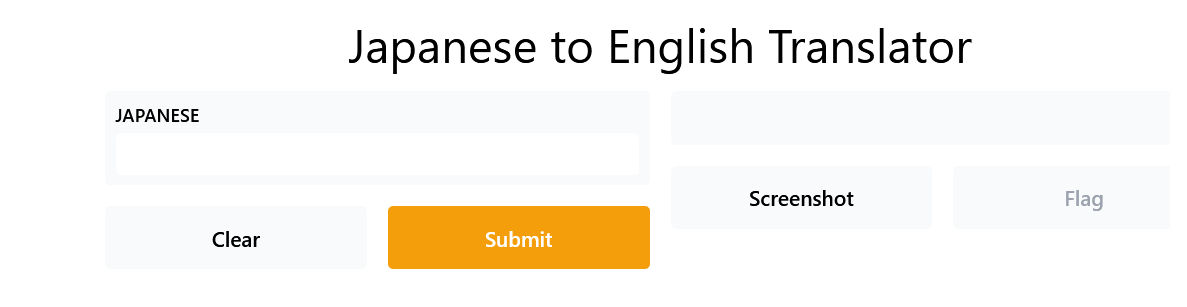